In [50]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## <span style="color: red;">Estudandos os dados:</span>

In [51]:
#verficando os dados
hypothesis = pd.read_csv('datasets/hypotheses_us.csv', sep = ';')
orders = pd.read_csv('datasets/orders_us.csv', nrows=100)
visits = pd.read_csv('datasets/visits_us.csv', nrows=100)

In [52]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [53]:
#avaliando a qualidade dos dados em orders

print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  100 non-null    int64  
 1   visitorId      100 non-null    int64  
 2   date           100 non-null    object 
 3   revenue        100 non-null    float64
 4   group          100 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


'date' sera convertido para datetime.

Apesar das colunas 'transactionId' e 'visitorId' não sequirem snake_case seguiremos assim como foi feito em aula.

In [54]:
#avaliando a qualidade dos dados em visits

print(visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


mesmo procedimento que em orders

In [55]:
orders = pd.read_csv('datasets/orders_us.csv', parse_dates=['date'])
visits = pd.read_csv('datasets/visits_us.csv', parse_dates=['date'])
print(orders.info())
print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


Depois de avaliado os dados, precisamos conferir se os dados fazem sentido para um teste A/B.
Iniciamos conferindo os grupos, que devem ser iguais ou com diferenças insignificantes.

In [56]:
print(orders['group'].value_counts())
print(visits['group'].value_counts())

group
B    640
A    557
Name: count, dtype: int64
group
A    31
B    31
Name: count, dtype: int64


os grupos estao perfeitamente divididos em visits, mas nao em orders, precisamos entender se essas diferenças são significativas.
Como 'orders' se trata do numero de pedidos alguns clientes podem ter feitos mais pedidos, vamos comparar a quantidades de clientes unicos.

In [57]:
ordersA = orders.query('group == "A"')
ordersB = orders.query('group == "B"')
print(ordersA['visitorId'].nunique())
print(ordersB['visitorId'].nunique())

503
586


Os valores nao batem.
Será que os usuarios podem estar sendo contados nos dois grupos?


In [58]:
orders_grouped = orders.groupby(['visitorId','group'], observed=True)['revenue'].sum()
print(orders_grouped)

visitorId   group
5114589     B          10.8
6958315     B          25.9
8300375     A          30.5
            B         165.7
11685486    A         100.4
                      ...  
4266935830  B        1220.2
4278982564  A         385.7
4279090005  B         105.3
4281247801  B          45.6
4283872382  B          60.6
Name: revenue, Length: 1089, dtype: float64


O visitante 8300375 tem compras nos dois grupos!!
devem ter outros casos

In [59]:
#agrupando dados por visitorId e group e somando a receita para ifentificar quem tem receita em A e B
orders_grouped = orders.groupby(['visitorId','group'], observed=True, as_index=False)['revenue'].sum()

#criando uma lista de visitantes duplicados, ou seja, aqueles que tem receita em A e B
list_duplicated_id = orders_grouped['visitorId']
list_duplicated_id = list_duplicated_id[list_duplicated_id.duplicated()].reset_index(drop=True)
print(list_duplicated_id.info())


<class 'pandas.core.series.Series'>
RangeIndex: 58 entries, 0 to 57
Series name: visitorId
Non-Null Count  Dtype
--------------  -----
58 non-null     int64
dtypes: int64(1)
memory usage: 596.0 bytes
None


Foram contados 58 usuarios com esse perfil. Um valor significativo, pois se trata de 10% dos usuarios de cada grupo.

In [60]:
orders_ = orders.query('visitorId not in @list_duplicated_id')
orders_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB


In [61]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


Uma parcela significativa dos dados foi comprometida.

Sera usado os dfs para as proximas etapas:
- hypothesis
- orders_
- visits

## <span style="color: red;">Priorizando hipóteses:</span>

Será usado nessa etapa alguns métodos de priorização das hipóteses.
- ICE
- RICE

Por fim explicaremos a diferença nos resultados.

In [62]:
ice = pd.DataFrame()
ice['hypothesis'] = hypothesis['hypothesis']
ice['priority'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['effort']
ice = ice.sort_values(by='priority', ascending=False)
ice

,hypothesis,priority
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


In [63]:
rice = pd.DataFrame()
rice['hypothesis'] = hypothesis['hypothesis']
rice['priority'] = hypothesis['reach']*hypothesis['impact'] * hypothesis['confidence'] / hypothesis['effort']
rice = rice.sort_values(by='priority', ascending=False)
rice

,hypothesis,priority
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


In [64]:
hypothesis

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


A diferença entre as duas metodologias é o fator 'reach' que é a quantidade de usuarios atingidos pela atualização.

Podemos ver que como a hipotese 8 pontua 1 no fator reach ela caiu muito na priorização entre as metodologias(de primeiro para quinto).
Enquanto que a hipostese 7 que estava em terceiro, despontou para primeiro com folga. Apenas pelo numero de usuários afetados.

## <span style="color: red;">Análise do teste A/B:</span>

Será feito uma análise completa dos resultados do teste A/B.

- 01. Gráfico da receita acumulada por grupo.
- 02. Gráfico do tamanho médio acumulado do pedido por grupo.
- 03. Gráfico da diferença relativa no tamanho medio acumulado do pedido para os grupos.
- 04. Calculo da taxa de conversão de cada grupo como a proporção de pedidos para o número de visitas para cada dia. Traçando as taxas de conversão diárias dos dois grupos.
- 05. Gráfico da diferença relativa na conversão cumulativa entre os grupos.
- 06. Calculo dos percentis 95 e 99 para o número de pedidos por usuário. Definindo o ponto que se torna uma anomalia.
- 07. Gráfico de dispersão dos preços dos pedidos.
- 08. Calculo dos percentis 95 e 99 dos preços dos pedidos. Definindo o ponto que se torna uma anomalia.
- 09. Calculo da significância estatística da difenrenca na conversão entre grupos usando os dados brutos.
- 10. Calculo da significância estatística da diferença no tamanho médio do pedido entre grupos usando os dados brutos.
- 11. Calculo da significância estatística da diferença na conversão entre grupos usando os dados filtrados.
- 12. Calculo da significância estatística da diferença no tamanho médio do pedido entre grupos usando os dados filtrados.
- 13. Tomando uma decisão com base nos resultados do teste:
        - A: Pare o teste e considere um dos grupos o líder.
        - B: Pare o teste e conclua que não há diferença entre os grupos.
        - C: Continue o teste.



In [65]:
visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [66]:
orders_

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [68]:
dates_groups = orders_[['date', 'group']].drop_duplicates().sort_values(by=['date', 'group'])

orders_aggregated = dates_groups.apply(lambda x: orders_[(orders_['date'] <= x['date']) & (orders_['group'] == x['group'])].agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis=1).sort_values(by=['date', 'group'])
print(orders_aggregated.head(10))  

#receita acumulada por dia e grupo

          date group  transactionId  visitorId  revenue
55  2019-08-01     A             23         19   2266.6
66  2019-08-01     B             17         17    967.2
175 2019-08-02     A             42         36   3734.9
173 2019-08-02     B             40         39   3535.3
291 2019-08-03     A             66         60   5550.1
383 2019-08-03     B             54         53   4606.9
499 2019-08-04     A             77         71   6225.6
498 2019-08-04     B             68         66   6138.5
719 2019-08-05     A             99         92   7623.6
699 2019-08-05     B             89         87   7587.8


In [69]:
visits_aggregated = dates_groups.apply(lambda x: visits[(visits['date'] <= x['date']) & (visits['group'] == x['group'])].agg({'date':'max', 'group':'max', 'visits':'sum'}), axis=1).sort_values(by=['date', 'group'])
print(visits_aggregated.head(10))

#visitates acumulados por dia e grupo

          date group  visits
55  2019-08-01     A     719
66  2019-08-01     B     713
175 2019-08-02     A    1338
173 2019-08-02     B    1294
291 2019-08-03     A    1845
383 2019-08-03     B    1803
499 2019-08-04     A    2562
498 2019-08-04     B    2573
719 2019-08-05     A    3318
699 2019-08-05     B    3280


In [71]:
cumulative_data = orders_aggregated.merge(visits_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']
cumulative_data.head(10)

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845
5,2019-08-03,B,54,53,4606.9,1803
6,2019-08-04,A,77,71,6225.6,2562
7,2019-08-04,B,68,66,6138.5,2573
8,2019-08-05,A,99,92,7623.6,3318
9,2019-08-05,B,89,87,7587.8,3280


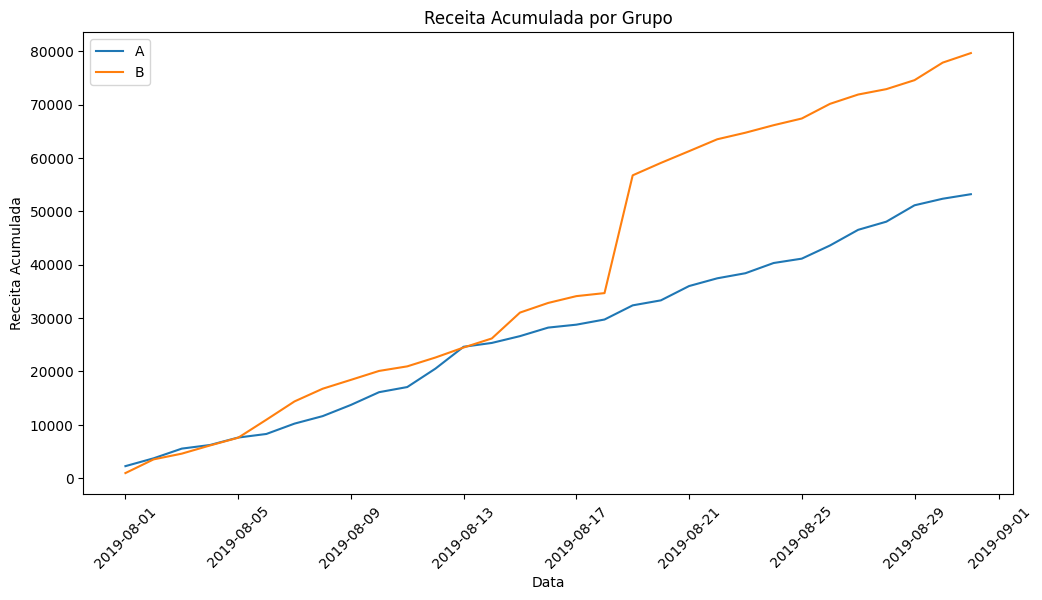

In [79]:
cumulativeRevenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Receita Acumulada por Grupo')

plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Receita Acumulada')

plt.legend()
plt.show()

As vendas estavão em pé de igualdade até o meio de agosto, houve um salto na receita e depois o crescimento relativo entre as duas se manteve. Existe a chance de um unico dia atípico ou até mesmo uma unica venda que tenha feito essa diferença.

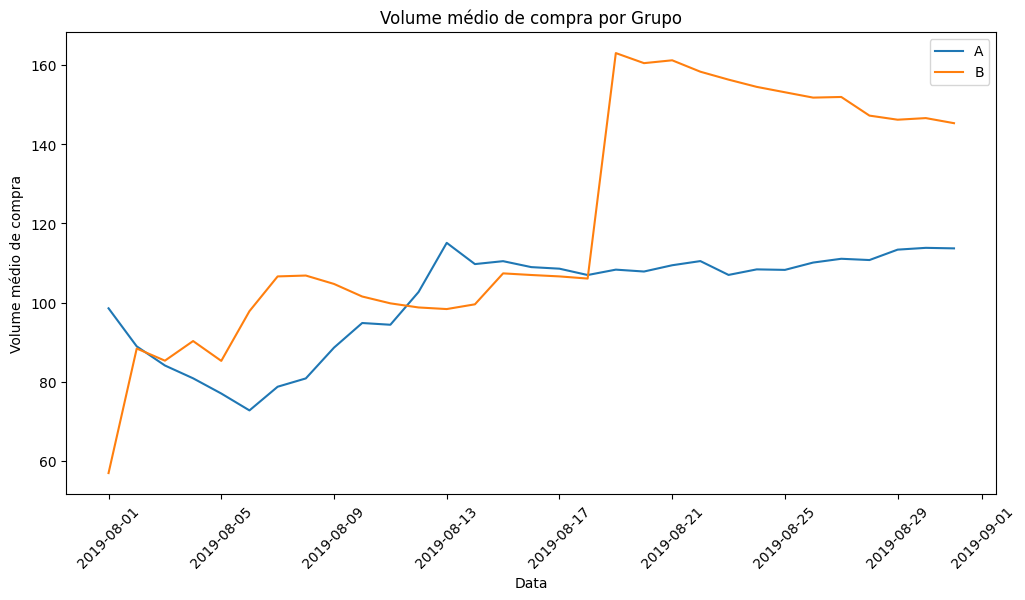

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Volume médio de compra por Grupo')
plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Volume médio de compra')
plt.legend()
plt.show()

Nota-se novamente o impacto de um unico evento no meio do mês de agosto.
A curva do grupo A já se estabilizou, porem por conta de uma tendência de queda no grupo B este ainda não se estabilizou.